In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import *
from catboost import CatBoostRegressor
import warnings as w
w.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

## 이전 설문조사 결과 참고용

In [2]:
answer = pd.read_csv("../data/4.체감안전도_통계(2017~2019).csv")

## 제출양식 맞추기 위함

In [3]:
sub = pd.read_csv("../data/25.결과제출양식.csv")
pol_order = list(sub['경찰서명'])

for i in range(len(pol_order)):
    pol_order[i] = "jur_stn_"+pol_order[i]
    pol_order[i] = pol_order[i].replace(" ","")

In [45]:
tqq = pd.read_csv("q3_train.csv")#,index_col=0)

In [4]:
train_data = pd.read_csv("q3_train.csv")#,index_col=0)
target_data = pd.read_csv("q3_target.csv")#,index_col=0)

target_data.reset_index(drop=True,inplace=True)

In [5]:
train_data = pd.get_dummies(train_data)
target_data = pd.get_dummies(target_data)

In [6]:
target_data['상반기'] =target_data['date_2020(상반기)']
del target_data['date_2020(상반기)'],target_data['date_2020(하반기)']

In [7]:
train_data

,total_cnt,ofn_sx_기타불명,ofn_sx_남,ofn_sx_여,ofn_sx_성비,ofn_age_10대 이하,ofn_age_20~30대,ofn_age_40~50대,ofn_age_60~70대,ofn_age_80대 이상,...,jur_stn_수원서부경찰서,jur_stn_수원중부경찰서,jur_stn_진주경찰서,jur_stn_진해경찰서,jur_stn_창원서부경찰서,jur_stn_창원중부경찰서,date_2018(상반기),date_2018(하반기),date_2019(상반기),date_2019(하반기)
0,203,3,157,43,365.1,0,29,59,12,0,...,0,0,0,0,0,0,1,0,0,0
1,186,1,152,33,460.6,0,23,52,8,0,...,0,0,0,0,0,0,0,1,0,0
2,213,3,169,41,412.2,0,25,46,12,0,...,0,0,0,0,0,0,0,0,1,0
3,243,2,184,57,322.8,0,27,67,13,0,...,0,0,0,0,0,0,0,0,0,1
4,254,0,195,59,330.5,0,31,78,15,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,338,8,249,81,307.4,0,48,91,19,0,...,0,0,0,0,1,0,0,0,0,1
160,338,4,264,70,377.1,0,51,93,9,0,...,0,0,0,0,0,1,1,0,0,0
161,349,7,268,74,362.2,0,58,116,10,0,...,0,0,0,0,0,1,0,1,0,0
162,315,9,229,77,297.4,0,53,77,9,0,...,0,0,0,0,0,1,0,0,1,0


In [8]:
y = train_data['ta_safety_q3']

In [9]:
train_data['상반기'] = ( train_data['date_2018(상반기)'] | train_data['date_2019(상반기)'] )
del train_data['date_2018(상반기)'],train_data['date_2018(하반기)'],train_data['date_2019(상반기)'],train_data['date_2019(하반기)']

In [10]:
preprocessing_col = pol_order + [
'total_cnt',
 'ofn_sx_기타불명',
 'ofn_sx_남',
 'ofn_sx_여',
 'ofn_sx_성비',
 'ofn_age_10대 이하',
 'ofn_age_20~30대',
 'ofn_age_40~50대',
 'ofn_age_60~70대',
 'ofn_age_80대 이상',
 'ofn_age_미분류',
 'vic_sx_기타불명',
 'vic_sx_남',
 'vic_sx_여',
 'vic_sx_성비',
 'vic_age_10대 이하',
 'vic_age_20~30대',
 'vic_age_40~50대',
 'vic_age_60~70대',
 'vic_age_80대 이상',
 'vic_age_미분류',
 'month_1m',
 'month_2m',
 'month_3m',
 'month_4m',
 'month_5m',
 'month_6m',
 'acc_type_차대사람',
 'acc_type_차대차',
 'acc_type_차량단독',
 'acc_case_공작물충돌',
 'acc_case_기타',
 'acc_case_길가장자리구역통행중',
 'acc_case_도로외이탈',
 'acc_case_보도통행중',
 'acc_case_전도전복',
 'acc_case_정면충돌',
 'acc_case_주/정차차량 충돌',
 'acc_case_차도통행중',
 'acc_case_추돌',
 'acc_case_측면충돌',
 'acc_case_횡단중',
 'acc_case_후진중충돌',
 'pub_cnt',
 'poor_num',
 'age_합계',
 'age_15세미만',
 'age_15~64세',
 'age_65세이상',
 'age_평균연령',
 'sx_rate_합계',
 'sx_rate_15세미만',
 'sx_rate_15~64세',
 'sx_rate_65세이상',
 'foreign_num',
 'cctv_cnt',
 'bell_us',
 'light_cnt',
'상반기']

In [11]:
train_data = train_data[preprocessing_col]
target_data = target_data[preprocessing_col]

In [12]:
idx_list = []
for i in answer.index:
    if '서' in answer.loc[i,'medium_category']:
        idx_list.append(i)

In [13]:
answer = answer.loc[idx_list,:]
answer.reset_index(drop=True,inplace=True)

In [14]:
answer_gb = answer.groupby('medium_category').mean()

In [15]:
X = train_data

In [16]:
target_data.sort_values(pol_order,ascending=False,inplace=True)
target_data.reset_index(drop=True,inplace=True)

In [17]:
tar_sang = target_data[target_data['상반기']==1]
tar_ha = target_data[target_data['상반기']==1]

tar_sang.reset_index(drop=True,inplace=True)
tar_ha.reset_index(drop=True,inplace=True)

In [18]:
X = X.iloc[:,41:]
tar_ha = tar_ha.iloc[:,41:]
tar_sang = tar_sang.iloc[:,41:]

# Mamuri

In [19]:
model = CatBoostRegressor(iterations=800,silent=True).fit(X, y)

In [20]:
sang_pred = model.predict(tar_sang)
ha_pred = model.predict(tar_ha)

In [21]:
sang_td = tar_sang
ha_td = tar_ha

In [22]:
sang_td['pred'] = sang_pred
ha_td['pred'] = ha_pred

In [23]:
sang = sang_td['pred'] * 0.1075
ha = ha_td['pred'] * 0.9075

In [24]:
df = pd.DataFrame(list(zip(model.feature_importances_,X.columns)))
df.columns = ['weight','columns']
df.sort_values(['weight'],axis=0,ascending=False)

,weight,columns
50,6.607908,sx_rate_합계
57,5.557649,light_cnt
52,5.339294,sx_rate_15~64세
58,4.153700,상반기
32,3.744762,acc_case_길가장자리구역통행중
38,3.584920,acc_case_차도통행중
44,3.450403,poor_num
43,3.377784,pub_cnt
39,3.088853,acc_case_추돌
49,2.994735,age_평균연령


In [49]:
X.loc[103,:]

total_cnt                1242.0
ofn_sx_기타불명                24.0
ofn_sx_남                 1020.0
ofn_sx_여                  198.0
ofn_sx_성비                 515.2
ofn_age_10대 이하              0.0
ofn_age_20~30대            192.0
ofn_age_40~50대            301.0
ofn_age_60~70대             92.0
ofn_age_80대 이상              0.0
ofn_age_미분류                24.0
vic_sx_기타불명                36.0
vic_sx_남                  900.0
vic_sx_여                  306.0
vic_sx_성비                 294.1
vic_age_10대 이하              1.0
vic_age_20~30대            257.0
vic_age_40~50대            248.0
vic_age_60~70대             65.0
vic_age_80대 이상              1.0
vic_age_미분류                36.0
month_1m                  209.0
month_2m                  210.0
month_3m                  188.0
month_4m                  238.0
month_5m                  195.0
month_6m                  202.0
acc_type_차대사람             288.0
acc_type_차대차              919.0
acc_type_차량단독              35.0
acc_case_공작물충돌              4.0
acc_case

In [76]:
# col_num = 41
# row=140
# print(tqq.loc[row,'jur_stn'])
# tester = (X.loc[row,:]).copy()
# target_col_value = X.columns[col_num]
# print("- 타겟 피쳐 : ",target_col_value,"\n- 값 : ", tester[target_col_value])
# print("- 기존 만족도 : ",y[row])
# print("- Feature Importance : ",model.feature_importances_[col_num])
# target_var_value = 1.1
# tester[target_col_value] = tester[target_col_value] * target_var_value
# print("- 수치 10% 증가 시 예측 만족도 : ",model.predict(np.array(tester)))
# print("* 변화량 : ",(model.predict(np.array(tester))-y[row]))

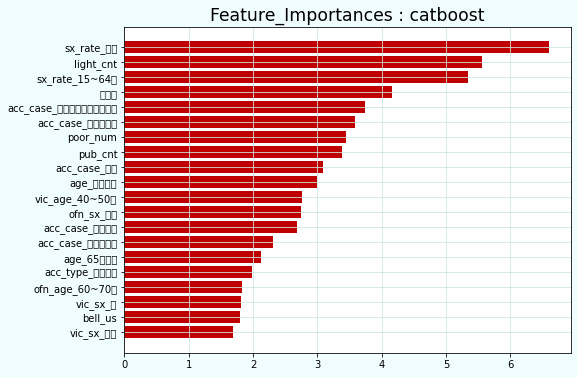

In [26]:
impotances = model.feature_importances_
feature_list = list(zip(model.feature_importances_,X.columns))
feature_list.sort(reverse=True)
feature_list=feature_list[:20]
feature_list.sort(reverse=False)
feature_df = pd.DataFrame(feature_list,columns=["score","feature"])
plt.figure(figsize=(8,6),facecolor="#F0FDFF")
plt.title("Feature_Importances : {}".format(str(model).split('.')[0].split('<')[-1]), fontsize="xx-large")
plt.barh(feature_df["feature"],feature_df["score"],color="#C00000")
plt.grid(color="#CFE8E1")

In [27]:
model.

SyntaxError: invalid syntax (<ipython-input-27-e5c9403477cf>, line 1)

In [ ]:
# haban_data = answer[answer['large_category']=='2019 하반기(경찰서별)']['ta_safety_q3']
# sangban_data = answer[answer['large_category']=='2019 상반기(경찰서별)']['ta_safety_q3']
ha.reset_index(drop=True,inplace=True)
sang.reset_index(drop=True,inplace=True)

In [ ]:
prediction = pd.Series(sang+ha)

In [ ]:
# result = (prediction * 0.8 ) + (haban_data * 0.15) + (sangban_data * 0.05)

In [ ]:
prediction.to_csv("q3_result.csv")